In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from Misc.Functions.Plots import *

from Misc.Functions.DataProduction import *

from Misc.Functions.SupportingFunctions import *

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import plotly.graph_objects as go







run_list=[285490,286498,287987,288543,289413,289733,291970,293528]
color_list_=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:olive','tab:cyan']


<Axes: >

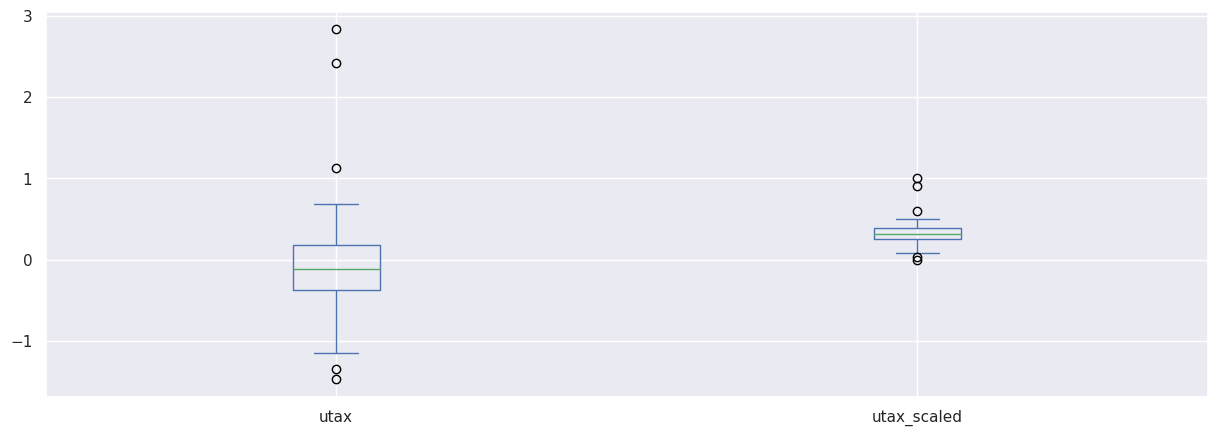

In [2]:
# Preprocessing the data for analysis.
dataProduction=dataProd()
mix_=dataProduction.multipleRun(285490,286498,287987,288543,289413,289733,291970,293528)
mix=mix_.copy()
pedestalOnly=pd.DataFrame(index=np.arange(18)+1)
planes_list=['UTaX', 'UTaU', 'UTbV', 'UTbX']

for i,v in enumerate(run_list):
    for plane in planes_list:
        temp_=mix[v].loc[(mix[v,'Plane']==plane)][['Side','Position','PedestalValue']]
        temp_['Stave']=temp_['Side']+temp_['Position'].astype(str)
        temp_.drop(['Side','Position'],axis=1,inplace=True)
        pedestalOnly[['Stave','Run'+str(i+1)+'_'+plane]]=temp_.groupby(['Stave']).agg('mean')['PedestalValue'].reset_index()




pedestalOnly_=pedestalOnly.drop(['Stave'],axis=1).fillna(0)

probabilities_=pd.DataFrame(softmax(pedestalOnly_),columns=pedestalOnly_.columns,index=np.arange(18)+1)
probabilities_


utax_=pedestalOnly_[pedestalOnly_.filter(regex='UTaX').columns]
utax=utax_.values.flatten()
ts=pd.DataFrame(index=np.arange(144))
ts['utax']=utax
ts=ts[ts['utax']!=0]
# ts=np.abs(ts)

scaler = MinMaxScaler(feature_range=(0, 1))


# Fit and transform the data
ts['utax_scaled'] = scaler.fit_transform(ts[['utax']])
ts.plot(kind='box')

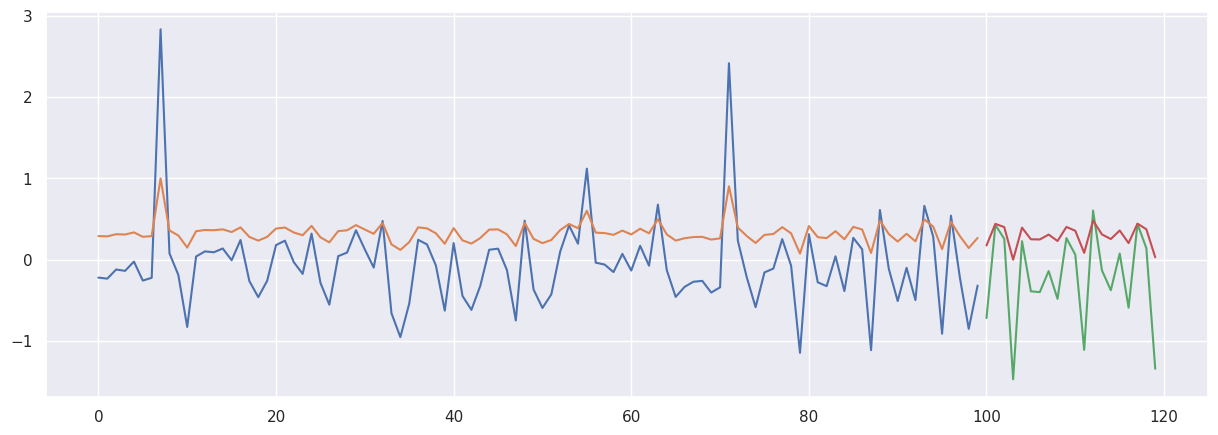

In [3]:
train=ts.head(100)
test=ts.tail(20)

plt.plot(train)
plt.plot(test)
plt.show()

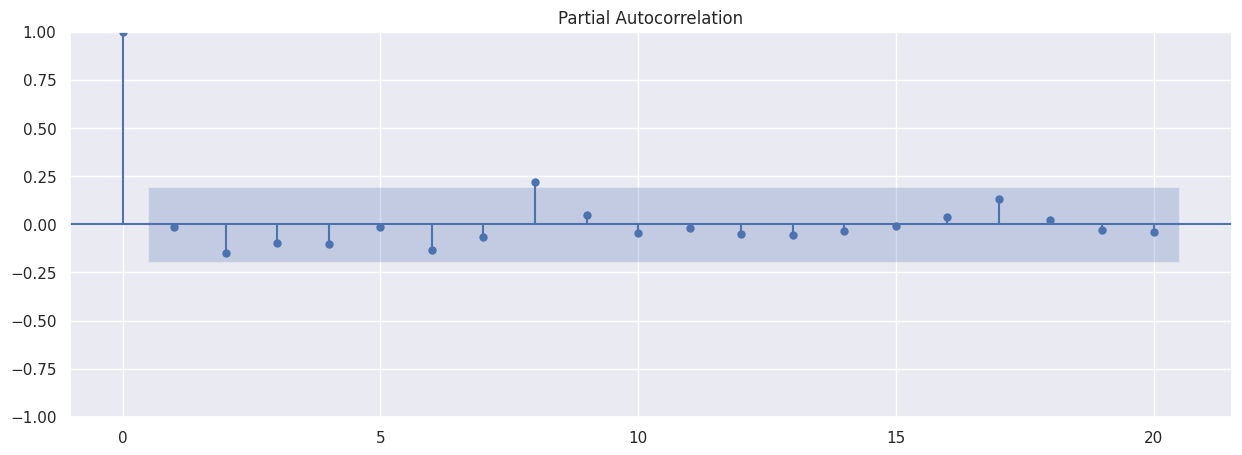

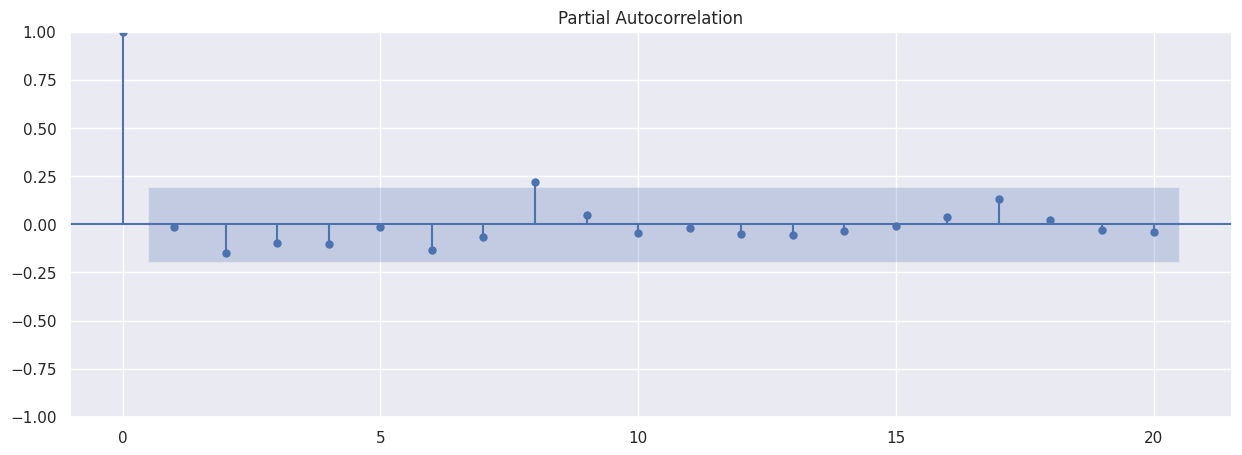

In [4]:
#finding I
plot_pacf(train['utax_scaled'])

In [5]:
#Looping for the parameters.

d=0
loss=[]
for p in range(15):
    for q in range(10):

        model = ARIMA(train['utax_scaled'], order=(p,d,q))
        model_fit = model.fit()

        # Summary of the model
        # print(model_fit.summary())
        forecast = model_fit.forecast(steps=20)  # Forecasting next 12 periods (1 year)
        # print(forecast)

        loss_=np.sqrt(mean_squared_error(test['utax_scaled'],forecast))
        loss.append((p, d, q, loss_))

/home/hashmi/miniconda3/envs/box/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hashmi/miniconda3/envs/box/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hashmi/miniconda3/envs/box/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hashmi/miniconda3/envs/box/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hashmi/miniconda3/envs

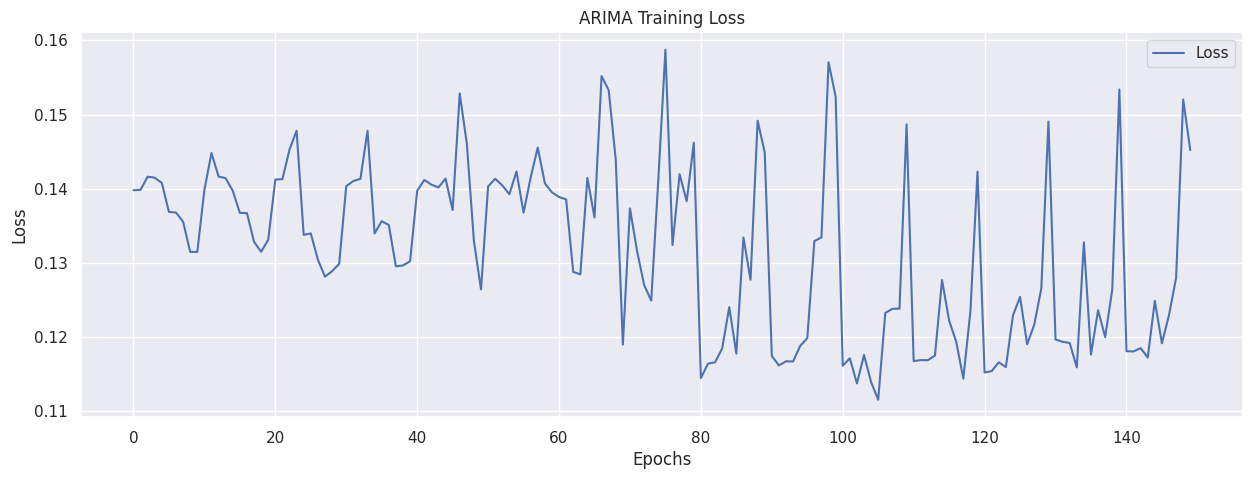

In [6]:
lossData=pd.DataFrame(loss,columns=['p','d','q','loss'])
lossData

plt.title('ARIMA Training Loss')

plt.plot(lossData['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



file_path='./Misc/Plots/TimeDependent/'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt.savefig(os.path.join(file_path,"ArimaLoss.png"))

plt.show()

In [7]:
# Create an interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=lossData['loss'],
    mode='lines',
    name='Loss'
))

fig.update_layout(
    title='Model Loss Over Time',
    xaxis_title='Epoch',
    yaxis_title='Loss'
)

# Show the plot
fig.show()


In [8]:
lossData.sort_values(by='loss').head(20)

,p,d,q,loss
105,10,0,5,0.111525
102,10,0,2,0.113722
104,10,0,4,0.113900
117,11,0,7,0.114382
80,8,0,0,0.114449
120,12,0,0,0.115193
121,12,0,1,0.115392
133,13,0,3,0.115880
123,12,0,3,0.115934
100,10,0,0,0.116110


/home/hashmi/miniconda3/envs/box/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



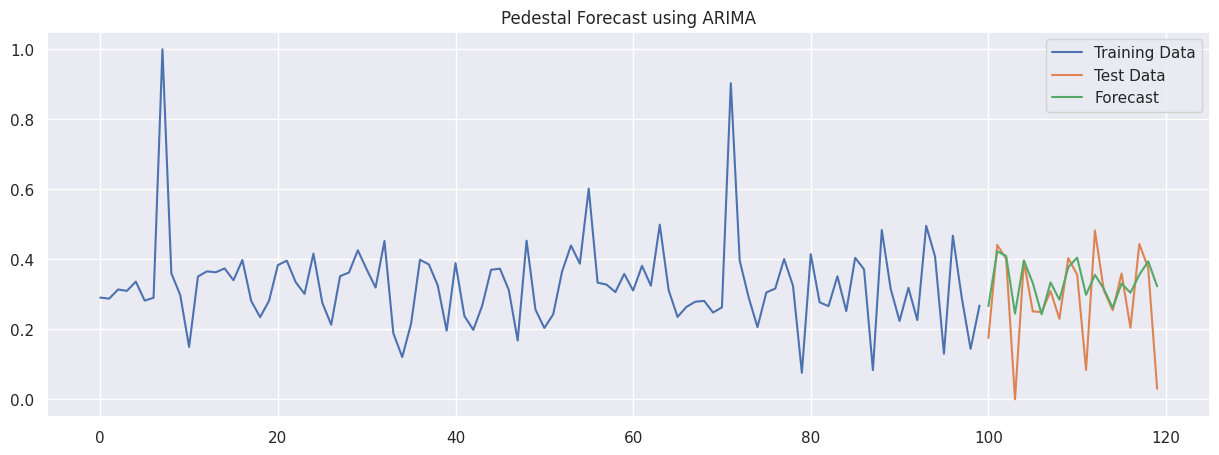

In [9]:
model = ARIMA(train['utax_scaled'], order=(10,0,5))  # Example order, typically chosen through model selection criteria
model_fit = model.fit()

# Summary of the model
# print(model_fit.summary())
forecast = model_fit.forecast(steps=20)  # Forecasting next 12 periods (1 year)
# print(forecast)

plt.plot(train['utax_scaled'],label='Training Data')
plt.plot(test['utax_scaled'],label = 'Test Data')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.title('Pedestal Forecast using ARIMA')

plt.savefig('./Misc/Plots/TimeDependent/ArimaPrediction.png')

plt.show()
